<a href="https://colab.research.google.com/github/cohitai/AI_notebooks/blob/main/VAE/VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Variational AutoEncoder = (encoder= Recognition model, decoder=Generative model)+ Variational loss.

 Variational loss = ELBO (evidence lower bound).



In [1]:
#ToDO: visualizations of the latent space, KL divergence explanations, Generative data. 
### Go over these: 
# Not sure I have the "right" variational loss. 
# https://avandekleut.github.io/vae/
# https://www.jeremyjordan.me/variational-autoencoders/
# https://gaussian37.github.io/deep-learning-chollet-8-4/
# simplify NN ? (How many ResNet layers/Blocks? are actiually meaningfull for a baseline.)
# output doesn't converge well. (check loss ? epochs adjustments/learning rate?)
# plot the loss
# change reconstruction loss to recons_loss =F.mse_loss(recons, input).

# The loss depends heavily on the BS. 
# Compare the loss with the pretrained VAE model(Huggingfaces). 
# sum() or mean() in loss , and kl.sum() or kl.mean() ? 


In [1]:
import torch 
import torchvision
from torch import nn
import torch.nn.functional as F
import numpy as np
import os
import math

print("Working directory:", os.getcwd())
device="cuda"

Working directory: /content


In [2]:
!nvidia-smi

Mon Nov 14 16:13:59 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
## download cifar10 data

In [4]:
# !wget https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz 

--2022-11-14 11:42:17--  https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M  86.9MB/s    in 1.9s    

2022-11-14 11:42:19 (86.9 MB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]



In [5]:
# !ls

cifar-10-python.tar.gz	sample_data


In [6]:
# !tar -xvf cifar-10-python.tar.gz

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


In [7]:
# !ls -al cifar-10-batches-py

total 181884
drwxr-xr-x 2 2156 1103     4096 Jun  4  2009 .
drwxr-xr-x 1 root root     4096 Nov 14 11:42 ..
-rw-r--r-- 1 2156 1103      158 Mar 31  2009 batches.meta
-rw-r--r-- 1 2156 1103 31035704 Mar 31  2009 data_batch_1
-rw-r--r-- 1 2156 1103 31035320 Mar 31  2009 data_batch_2
-rw-r--r-- 1 2156 1103 31035999 Mar 31  2009 data_batch_3
-rw-r--r-- 1 2156 1103 31035696 Mar 31  2009 data_batch_4
-rw-r--r-- 1 2156 1103 31035623 Mar 31  2009 data_batch_5
-rw-r--r-- 1 2156 1103       88 Jun  4  2009 readme.html
-rw-r--r-- 1 2156 1103 31035526 Mar 31  2009 test_batch


In [12]:
# import os.path as osp
# path = "./cifar-10-batches-py"
# def unpickle(file):
#     import pickle
#     with open(file, 'rb') as fo:
#         dict = pickle.load(fo, encoding='bytes')
#     return dict

# !ls $path

# c10_data = unpickle(osp.join(path,"data_batch_1"))
# print(c10_data.keys())

# # extract c10 data --> images,labels
# images = c10_data[b"data"].reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("uint8") # (10000,3072)
# labels = c10_data[b"labels"]
# #
# print("Data Shape",images.shape)

batches.meta  data_batch_2  data_batch_4  readme.html
data_batch_1  data_batch_3  data_batch_5  test_batch
dict_keys([b'batch_label', b'labels', b'data', b'filenames'])
Data Shape (10000, 32, 32, 3)


Model Blocks: - DownEncoderBlock2D
              - UpDecoderBlock2D
              - ResnetBlock
              - Downsample2D
              - Upsample2D
              - AttentionBlockNew
              - UNetMidBlock2D
              - Encoder
              - Decoder

In [3]:
class DownEncoderBlock2D(nn.Module):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        dropout: float = 0.0, 
        num_layers: int = 1,
        resnet_eps: float = 1e-6,
        resnet_time_scale_shift: str = "default",
        resnet_act_fn: str = "swish",
        resnet_groups: int = 32,
        resnet_pre_norm: bool = True,
        output_scale_factor=1.0,
        add_downsample=True,
        downsample_padding=1,
    ):
        super().__init__()
        resnets = []

        for i in range(num_layers):
            in_channels = in_channels if i == 0 else out_channels
            resnets.append(
                ResnetBlock(
                    in_channels=in_channels,
                    out_channels=out_channels,
                    temb_channels=None,
                    eps=resnet_eps,
                    groups=resnet_groups,
                    dropout=dropout,
                    time_embedding_norm=resnet_time_scale_shift,
                    non_linearity=resnet_act_fn,
                    output_scale_factor=output_scale_factor,
                    pre_norm=resnet_pre_norm,
                )
            )

        self.resnets = nn.ModuleList(resnets)

        if add_downsample:
            self.downsamplers = nn.ModuleList(
                [
                    Downsample2D(
                        in_channels, use_conv=True, out_channels=out_channels, padding=downsample_padding, name="op"
                    )
                ]
            )
        else:
            self.downsamplers = None

    def forward(self, hidden_states):
        for resnet in self.resnets:
            hidden_states = resnet(hidden_states, temb=None)

        if self.downsamplers is not None:
            for downsampler in self.downsamplers:
                hidden_states = downsampler(hidden_states)

        return hidden_states

class UpDecoderBlock2D(nn.Module):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        dropout: float = 0.0,
        num_layers: int = 1,
        resnet_eps: float = 1e-6,
        resnet_time_scale_shift: str = "default",
        resnet_act_fn: str = "swish",
        resnet_groups: int = 32,
        resnet_pre_norm: bool = True,
        output_scale_factor=1.0,
        add_upsample=True,
    ):
        super().__init__()
        resnets = []

        for i in range(num_layers):
            input_channels = in_channels if i == 0 else out_channels

            resnets.append(
                ResnetBlock(
                    in_channels=input_channels,
                    out_channels=out_channels,
                    temb_channels=None,
                    eps=resnet_eps,
                    groups=resnet_groups,
                    dropout=dropout,
                    time_embedding_norm=resnet_time_scale_shift,
                    non_linearity=resnet_act_fn,
                    output_scale_factor=output_scale_factor,
                    pre_norm=resnet_pre_norm,
                )
            )

        self.resnets = nn.ModuleList(resnets)

        if add_upsample:
            self.upsamplers = nn.ModuleList([Upsample2D(out_channels, use_conv=True, out_channels=out_channels)])
        else:
            self.upsamplers = None

    def forward(self, hidden_states):
        for resnet in self.resnets:
            hidden_states = resnet(hidden_states, temb=None)

        if self.upsamplers is not None:
            for upsampler in self.upsamplers:
                hidden_states = upsampler(hidden_states)

        return hidden_states

  
    
class ResnetBlock(nn.Module):
    def __init__(
        self,
        *,
        in_channels,
        out_channels=None,
        conv_shortcut=False,
        dropout=0.0,
        temb_channels=512,
        groups=32,
        groups_out=None,
        pre_norm=True,
        eps=1e-6,
        non_linearity="swish",
        time_embedding_norm="default",
        kernel=None,
        output_scale_factor=1.0,
        use_nin_shortcut=None,
        up=False,
        down=False,
    ):
        super().__init__()
        self.pre_norm = pre_norm
        self.pre_norm = True
        self.in_channels = in_channels
        out_channels = in_channels if out_channels is None else out_channels
        self.out_channels = out_channels
        self.use_conv_shortcut = conv_shortcut
        self.time_embedding_norm = time_embedding_norm
        self.up = up
        self.down = down
        self.output_scale_factor = output_scale_factor

        if groups_out is None:
            groups_out = groups

        self.norm1 = torch.nn.GroupNorm(num_groups=groups, num_channels=in_channels, eps=eps, affine=True)

        self.conv1 = torch.nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)

        if temb_channels is not None:
            self.time_emb_proj = torch.nn.Linear(temb_channels, out_channels)
        else:
            self.time_emb_proj = None

        self.norm2 = torch.nn.GroupNorm(num_groups=groups_out, num_channels=out_channels, eps=eps, affine=True)
        self.dropout = torch.nn.Dropout(dropout)
        self.conv2 = torch.nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)

        if non_linearity == "swish":
            self.nonlinearity = lambda x: F.silu(x)
        elif non_linearity == "mish":
            self.nonlinearity = Mish()
        elif non_linearity == "silu":
            self.nonlinearity = nn.SiLU()

        self.upsample = self.downsample = None
        if self.up:
            if kernel == "fir":
                fir_kernel = (1, 3, 3, 1)
                self.upsample = lambda x: upsample_2d(x, k=fir_kernel)
            elif kernel == "sde_vp":
                self.upsample = partial(F.interpolate, scale_factor=2.0, mode="nearest")
            else:
                self.upsample = Upsample2D(in_channels, use_conv=False)
        
        elif self.down:
            if kernel == "fir":
                fir_kernel = (1, 3, 3, 1)
                self.downsample = lambda x: downsample_2d(x, k=fir_kernel)
            elif kernel == "sde_vp":
                self.downsample = partial(F.avg_pool2d, kernel_size=2, stride=2)
            else:
                self.downsample = Downsample2D(in_channels, use_conv=False, padding=1, name="op")

        self.use_nin_shortcut = self.in_channels != self.out_channels if use_nin_shortcut is None else use_nin_shortcut

        self.conv_shortcut = None
    
        if self.use_nin_shortcut:
            self.conv_shortcut = torch.nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)

    def forward(self, x, temb, hey=False):
        h = x

        # print("LOG resnet_input",h.size())

        # make sure hidden states is in float32
        # when running in half-precision
        h = self.norm1(h.float()).type(h.dtype)
        h = self.nonlinearity(h)

        # if self.upsample is not None:
        #     x = self.upsample(x)
        #     h = self.upsample(h)
        # elif self.downsample is not None:
        #     x = self.downsample(x)
        #     h = self.downsample(h)

        h = self.conv1(h)

        # print("LOG temb:",temb is None)

        # if temb is not None:
        #     temb = self.time_emb_proj(self.nonlinearity(temb))[:, :, None, None]
        #     h = h + temb

        # make sure hidden states is in float32
        # when running in half-precision
        h = self.norm2(h.float()).type(h.dtype)
        h = self.nonlinearity(h)

        h = self.dropout(h)
        h = self.conv2(h)

        if self.conv_shortcut is not None:
            x = self.conv_shortcut(x)

        out = (x + h) / self.output_scale_factor

        return out

    def set_weight(self, resnet):
        self.norm1.weight.data = resnet.norm1.weight.data
        self.norm1.bias.data = resnet.norm1.bias.data

        self.conv1.weight.data = resnet.conv1.weight.data
        self.conv1.bias.data = resnet.conv1.bias.data

        if self.time_emb_proj is not None:
            self.time_emb_proj.weight.data = resnet.temb_proj.weight.data
            self.time_emb_proj.bias.data = resnet.temb_proj.bias.data

        self.norm2.weight.data = resnet.norm2.weight.data
        self.norm2.bias.data = resnet.norm2.bias.data

        self.conv2.weight.data = resnet.conv2.weight.data
        self.conv2.bias.data = resnet.conv2.bias.data

        if self.use_nin_shortcut:
            self.conv_shortcut.weight.data = resnet.nin_shortcut.weight.data
            self.conv_shortcut.bias.data = resnet.nin_shortcut.bias.data
            
            
class Downsample2D(nn.Module):
    """
    A downsampling layer with an optional convolution.
    :param channels: channels in the inputs and outputs. :param use_conv: a bool determining if a convolution is
    applied. :param dims: determines if the signal is 1D, 2D, or 3D. If 3D, then
                 downsampling occurs in the inner-two dimensions.
    """

    def __init__(self, channels, use_conv=False, out_channels=None, padding=1, name="conv"):
        super().__init__()
        self.channels = channels
        self.out_channels = out_channels or channels
        self.use_conv = use_conv
        self.padding = padding
        stride = 2
        self.name = name

        if use_conv:
            conv = nn.Conv2d(self.channels, self.out_channels, 3, stride=stride, padding=padding)
        else:
            assert self.channels == self.out_channels
            conv = nn.AvgPool2d(kernel_size=stride, stride=stride)

        # TODO(Suraj, Patrick) - clean up after weight dicts are correctly renamed
        if name == "conv":
            self.Conv2d_0 = conv
            self.conv = conv
        elif name == "Conv2d_0":
            self.conv = conv
        else:
            self.conv = conv

    def forward(self, x):
        assert x.shape[1] == self.channels
        if self.use_conv and self.padding == 0:
            pad = (0, 1, 0, 1)
            x = F.pad(x, pad, mode="constant", value=0)

        assert x.shape[1] == self.channels
        x = self.conv(x)

        # print('LOG',x)
        return x

class Upsample2D(nn.Module):

    """
    An upsampling layer with an optional convolution.
    :param channels: channels in the inputs and outputs. :param use_conv: a bool determining if a convolution is
    applied. :param dims: determines if the signal is 1D, 2D, or 3D. If 3D, then
                 upsampling occurs in the inner-two dimensions.
    """

    def __init__(self, channels, use_conv=False, use_conv_transpose=False, out_channels=None, name="conv"):
        super().__init__()
        self.channels = channels
        self.out_channels = out_channels or channels
        self.use_conv = use_conv
        self.use_conv_transpose = use_conv_transpose
        self.name = name

        conv = None
        if use_conv_transpose:
            conv = nn.ConvTranspose2d(channels, self.out_channels, 4, 2, 1)
        elif use_conv:
            conv = nn.Conv2d(self.channels, self.out_channels, 3, padding=1)

        # TODO(Suraj, Patrick) - clean up after weight dicts are correctly renamed
        if name == "conv":
            self.conv = conv
        else:
            self.Conv2d_0 = conv

    def forward(self, x):
        assert x.shape[1] == self.channels
        if self.use_conv_transpose:
            return self.conv(x)

        x = F.interpolate(x, scale_factor=2.0, mode="nearest")

        # TODO(Suraj, Patrick) - clean up after weight dicts are correctly renamed
        if self.use_conv:
            if self.name == "conv":
                x = self.conv(x)
            else:
                x = self.Conv2d_0(x)

        return x


class AttentionBlockNew(nn.Module):
    """
    An attention block that allows spatial positions to attend to each other. Originally ported from here, but adapted
    to the N-d case.
    https://github.com/hojonathanho/diffusion/blob/1e0dceb3b3495bbe19116a5e1b3596cd0706c543/diffusion_tf/models/unet.py#L66.
    Uses three q, k, v linear layers to compute attention
    """

    def __init__(
        self,
        channels,
        num_head_channels=None,
        num_groups=32,
        rescale_output_factor=1.0,
        eps=1e-5,
    ):
        super().__init__()
        self.channels = channels

        self.num_heads = channels // num_head_channels if num_head_channels is not None else 1
        self.num_head_size = num_head_channels
        self.group_norm = nn.GroupNorm(num_channels=channels, num_groups=num_groups, eps=eps, affine=True)

        # define q,k,v as linear layers
        self.query = nn.Linear(channels, channels)
        self.key = nn.Linear(channels, channels)
        self.value = nn.Linear(channels, channels)

        self.rescale_output_factor = rescale_output_factor
        self.proj_attn = nn.Linear(channels, channels, 1)

    def transpose_for_scores(self, projection: torch.Tensor) -> torch.Tensor:
        new_projection_shape = projection.size()[:-1] + (self.num_heads, -1)
        # move heads to 2nd position (B, T, H * D) -> (B, T, H, D) -> (B, H, T, D)
        new_projection = projection.view(new_projection_shape).permute(0, 2, 1, 3)
        return new_projection

    def forward(self, hidden_states):
        residual = hidden_states
        batch, channel, height, width = hidden_states.shape

        # norm
        hidden_states = self.group_norm(hidden_states)

        hidden_states = hidden_states.view(batch, channel, height * width).transpose(1, 2)

        # proj to q, k, v
        query_proj = self.query(hidden_states)
        key_proj = self.key(hidden_states)
        value_proj = self.value(hidden_states)

        # transpose
        query_states = self.transpose_for_scores(query_proj)
        key_states = self.transpose_for_scores(key_proj)
        value_states = self.transpose_for_scores(value_proj)

        # get scores
        scale = 1 / math.sqrt(math.sqrt(self.channels / self.num_heads))
        attention_scores = torch.matmul(query_states * scale, key_states.transpose(-1, -2) * scale)
        attention_probs = torch.softmax(attention_scores.float(), dim=-1).type(attention_scores.dtype)

        # compute attention output
        context_states = torch.matmul(attention_probs, value_states)

        context_states = context_states.permute(0, 2, 1, 3).contiguous()
        new_context_states_shape = context_states.size()[:-2] + (self.channels,)
        context_states = context_states.view(new_context_states_shape)

        # compute next hidden_states
        hidden_states = self.proj_attn(context_states)
        hidden_states = hidden_states.transpose(-1, -2).reshape(batch, channel, height, width)

        # res connect and rescale
        hidden_states = (hidden_states + residual) / self.rescale_output_factor
        return hidden_states

    def set_weight(self, attn_layer):
        self.group_norm.weight.data = attn_layer.norm.weight.data
        self.group_norm.bias.data = attn_layer.norm.bias.data

        if hasattr(attn_layer, "q"):
            self.query.weight.data = attn_layer.q.weight.data[:, :, 0, 0]
            self.key.weight.data = attn_layer.k.weight.data[:, :, 0, 0]
            self.value.weight.data = attn_layer.v.weight.data[:, :, 0, 0]

            self.query.bias.data = attn_layer.q.bias.data
            self.key.bias.data = attn_layer.k.bias.data
            self.value.bias.data = attn_layer.v.bias.data

            self.proj_attn.weight.data = attn_layer.proj_out.weight.data[:, :, 0, 0]
            self.proj_attn.bias.data = attn_layer.proj_out.bias.data
        elif hasattr(attn_layer, "NIN_0"):
            self.query.weight.data = attn_layer.NIN_0.W.data.T
            self.key.weight.data = attn_layer.NIN_1.W.data.T
            self.value.weight.data = attn_layer.NIN_2.W.data.T

            self.query.bias.data = attn_layer.NIN_0.b.data
            self.key.bias.data = attn_layer.NIN_1.b.data
            self.value.bias.data = attn_layer.NIN_2.b.data

            self.proj_attn.weight.data = attn_layer.NIN_3.W.data.T
            self.proj_attn.bias.data = attn_layer.NIN_3.b.data

            self.group_norm.weight.data = attn_layer.GroupNorm_0.weight.data
            self.group_norm.bias.data = attn_layer.GroupNorm_0.bias.data
        else:
            qkv_weight = attn_layer.qkv.weight.data.reshape(
                self.num_heads, 3 * self.channels // self.num_heads, self.channels
            )
            qkv_bias = attn_layer.qkv.bias.data.reshape(self.num_heads, 3 * self.channels // self.num_heads)

            q_w, k_w, v_w = qkv_weight.split(self.channels // self.num_heads, dim=1)
            q_b, k_b, v_b = qkv_bias.split(self.channels // self.num_heads, dim=1)

            self.query.weight.data = q_w.reshape(-1, self.channels)
            self.key.weight.data = k_w.reshape(-1, self.channels)
            self.value.weight.data = v_w.reshape(-1, self.channels)

            self.query.bias.data = q_b.reshape(-1)
            self.key.bias.data = k_b.reshape(-1)
            self.value.bias.data = v_b.reshape(-1)

            self.proj_attn.weight.data = attn_layer.proj.weight.data[:, :, 0]
            self.proj_attn.bias.data = attn_layer.proj.bias.data

class UNetMidBlock2D(nn.Module):
    def __init__(
        self,
        in_channels: int,
        temb_channels: int,
        dropout: float = 0.0,
        num_layers: int = 1,
        resnet_eps: float = 1e-6,
        resnet_time_scale_shift: str = "default",
        resnet_act_fn: str = "swish",
        resnet_groups: int = 32,
        resnet_pre_norm: bool = True,
        attn_num_head_channels=1,
        attention_type="default",
        output_scale_factor=1.0,
        **kwargs,
    ):
        super().__init__()

        self.attention_type = attention_type
        resnet_groups = resnet_groups if resnet_groups is not None else min(in_channels // 4, 32)

        # there is always at least one resnet
        resnets = [
            ResnetBlock(
                in_channels=in_channels,
                out_channels=in_channels,
                temb_channels=temb_channels,
                eps=resnet_eps,
                groups=resnet_groups,
                dropout=dropout,
                time_embedding_norm=resnet_time_scale_shift,
                non_linearity=resnet_act_fn,
                output_scale_factor=output_scale_factor,
                pre_norm=resnet_pre_norm,
            )
        ]
        attentions = []

        for _ in range(num_layers):
            attentions.append(
                AttentionBlockNew(
                    in_channels,
                    num_head_channels=attn_num_head_channels,
                    rescale_output_factor=output_scale_factor,
                    eps=resnet_eps,
                    num_groups=resnet_groups,
                )
            )
            resnets.append(
                ResnetBlock(
                    in_channels=in_channels,
                    out_channels=in_channels,
                    temb_channels=temb_channels,
                    eps=resnet_eps,
                    groups=resnet_groups,
                    dropout=dropout,
                    time_embedding_norm=resnet_time_scale_shift,
                    non_linearity=resnet_act_fn,
                    output_scale_factor=output_scale_factor,
                    pre_norm=resnet_pre_norm,
                )
            )

        self.attentions = nn.ModuleList(attentions)
        self.resnets = nn.ModuleList(resnets)

    def forward(self, hidden_states, temb=None, encoder_states=None):
        hidden_states = self.resnets[0](hidden_states, temb)
        for attn, resnet in zip(self.attentions, self.resnets[1:]):
            if self.attention_type == "default":
                hidden_states = attn(hidden_states)
            else:
                hidden_states = attn(hidden_states, encoder_states)
            hidden_states = resnet(hidden_states, temb)

        return hidden_states


class Encoder(nn.Module):
    def __init__(
        self,
        in_channels=3,
        out_channels=4,
        down_block_types=("DownEncoderBlock2D",),
        block_out_channels=(64,),
        layers_per_block=1,
        act_fn="silu",
        double_z=True,
    ):
        super().__init__()
        self.layers_per_block = layers_per_block
        self.conv_in = torch.nn.Conv2d(in_channels, block_out_channels[0], kernel_size=3, stride=1, padding=1)
        self.mid_block = None
        self.down_blocks = nn.ModuleList([])

        # down
        output_channel = block_out_channels[0]
        for i, _ in enumerate(down_block_types):
            input_channel = output_channel
            output_channel = block_out_channels[i]
            is_final_block = i == len(block_out_channels) - 1

            down_block = DownEncoderBlock2D(
                num_layers=self.layers_per_block,
                in_channels=input_channel,
                out_channels=output_channel,
                add_downsample=not is_final_block,
                resnet_eps=1e-6,
                resnet_act_fn=act_fn,
                downsample_padding=0,)

            self.down_blocks.append(down_block)

        # mid
        self.mid_block = UNetMidBlock2D(
            in_channels=block_out_channels[-1],
            resnet_eps=1e-6,
            resnet_act_fn=act_fn,
            output_scale_factor=1,
            resnet_time_scale_shift="default",
            attn_num_head_channels=None,
            resnet_groups=32,
            temb_channels=None,
        )

        # out
        num_groups_out = 32
        self.conv_norm_out = nn.GroupNorm(num_channels=block_out_channels[-1], num_groups=num_groups_out, eps=1e-6)
        self.conv_act = nn.SiLU()

        conv_out_channels = 2 * out_channels if double_z else out_channels
        self.conv_out = nn.Conv2d(block_out_channels[-1], conv_out_channels, 3, padding=1)

    def forward(self, x):
        
        sample = x
        sample = self.conv_in(sample)
        
        # down
        for down_block in self.down_blocks:
            sample = down_block(sample)

        # middle
        sample = self.mid_block(sample)

        # post-process
        sample = self.conv_norm_out(sample)
        sample = self.conv_act(sample)
        sample = self.conv_out(sample)

        return sample


class Decoder(nn.Module):
    def __init__(
        self,
        in_channels=3,
        out_channels=3,
        up_block_types=("UpDecoderBlock2D",),
        block_out_channels=(64,),
        layers_per_block=2,
        act_fn="silu",
    ):
        super().__init__()
        self.layers_per_block = layers_per_block

        self.conv_in = nn.Conv2d(in_channels, block_out_channels[-1], kernel_size=3, stride=1, padding=1)

        self.mid_block = None
        self.up_blocks = nn.ModuleList([])

        # mid
        self.mid_block = UNetMidBlock2D(
            in_channels=block_out_channels[-1],
            resnet_eps=1e-6,
            resnet_act_fn=act_fn,
            output_scale_factor=1,
            resnet_time_scale_shift="default",
            attn_num_head_channels=None,
            resnet_groups=32,
            temb_channels=None,
        )

        # up
        reversed_block_out_channels = list(reversed(block_out_channels))
        output_channel = reversed_block_out_channels[0]
        for i, up_block_type in enumerate(up_block_types):
            prev_output_channel = output_channel
            output_channel = reversed_block_out_channels[i]

            is_final_block = i == len(block_out_channels) - 1

            up_block = UpDecoderBlock2D(
            num_layers=self.layers_per_block + 1,
            in_channels=prev_output_channel,
            out_channels=output_channel,
            add_upsample=not is_final_block,
            resnet_eps=1e-6,
            resnet_act_fn=act_fn,
        )

            self.up_blocks.append(up_block)
            prev_output_channel = output_channel

        # out
        num_groups_out = 32
        self.conv_norm_out = nn.GroupNorm(num_channels=block_out_channels[0], num_groups=num_groups_out, eps=1e-6)
        self.conv_act = nn.SiLU()
        self.conv_out = nn.Conv2d(block_out_channels[0], out_channels, 3, padding=1)

    def forward(self, z):
        sample = z
        sample = self.conv_in(sample)

        # middle
        sample = self.mid_block(sample)

        # up
        for up_block in self.up_blocks:
            sample = up_block(sample)

        # post-process
        sample = self.conv_norm_out(sample)
        sample = self.conv_act(sample)
        sample = self.conv_out(sample)

        return sample

In [4]:
class DiagonalGaussianDistribution(object):
    def __init__(self, parameters, deterministic=False):
        self.parameters = parameters
        self.mean, self.logvar = torch.chunk(parameters, 2, dim=1)
        self.logvar = torch.clamp(self.logvar, -30.0, 20.0)
        self.deterministic = deterministic
        self.std = torch.exp(0.5 * self.logvar)
        self.var = torch.exp(self.logvar)
        if self.deterministic:
            self.var = self.std = torch.zeros_like(self.mean).to(device=self.parameters.device)

    def sample(self):
        x = self.mean + self.std * torch.randn(self.mean.shape).to(device=self.parameters.device)
        return x

    def kl(self, other=None):
        if self.deterministic:
            return torch.Tensor([0.0])
        else:
            if other is None:
                return 0.5 * torch.sum(torch.pow(self.mean, 2) + self.var - 1.0 - self.logvar, dim=[1, 2, 3])
            else:
                return 0.5 * torch.sum(
                    torch.pow(self.mean - other.mean, 2) / other.var
                    + self.var / other.var
                    - 1.0
                    - self.logvar
                    + other.logvar,
                    dim=[1, 2, 3],
                )

    def nll(self, sample, dims=[1, 2, 3]):
        if self.deterministic:
            return torch.Tensor([0.0])
        logtwopi = np.log(2.0 * np.pi)
        return 0.5 * torch.sum(logtwopi + self.logvar + torch.pow(sample - self.mean, 2) / self.var, dim=dims)

    def mode(self):
        return self.mean



encoder = Encoder(in_channels=3,
        out_channels=4,
        down_block_types=("DownEncoderBlock2D",),
        block_out_channels=(64,),
        layers_per_block=1,
        act_fn="silu",
        double_z=True)


decoder = Decoder(in_channels=4,
            out_channels=3,
            up_block_types=("UpDecoderBlock2D",),
            block_out_channels=(64,),
            layers_per_block=1,
            act_fn="silu")





    ##########################
    ##########################
    ##########################
#### AutoEncoder wrap- up class ####
    ##########################
    ##########################
    ##########################

class AutoencoderKL(nn.Module):
    def __init__(
        self,
        in_channels=3,
        out_channels=3,
        down_block_types=("DownEncoderBlock2D","DownEncoderBlock2D","DownEncoderBlock2D","DownEncoderBlock2D",),
        up_block_types=("UpDecoderBlock2D","UpDecoderBlock2D","UpDecoderBlock2D","UpDecoderBlock2D",),
        block_out_channels=(128, 256, 512, 512,),
        layers_per_block=2,
        act_fn="silu",
        latent_channels=4,
        sample_size=512,
    ):
        super().__init__()

        # pass init params to Encoder
        self.encoder = Encoder(
            in_channels=in_channels,
            out_channels=latent_channels,
            down_block_types=down_block_types,
            block_out_channels=block_out_channels,
            layers_per_block=layers_per_block,
            act_fn=act_fn,
            double_z=True,
        )

        # pass init params to Decoder
        self.decoder = Decoder(
            in_channels=latent_channels,
            out_channels=out_channels,
            up_block_types=up_block_types,
            block_out_channels=block_out_channels,
            layers_per_block=layers_per_block,
            act_fn=act_fn,
        )

        self.quant_conv = torch.nn.Conv2d(2 * latent_channels, 2 * latent_channels, 1)
        self.post_quant_conv = torch.nn.Conv2d(latent_channels, latent_channels, 1) 
        self.kl = 0

    def encode(self, x):
        h = self.encoder(x)
        moments = self.quant_conv(h)
        posterior = DiagonalGaussianDistribution(moments)
        return posterior

    def decode(self, z):
        z = self.post_quant_conv(z)
        dec = self.decoder(z)
        return dec

    def forward(self, sample, sample_posterior=False):
        x = sample
        posterior = self.encode(x)
        if sample_posterior:
            z = posterior.sample()
        else:
            z = posterior.mode()
        dec = self.decode(z)
        self.kl=posterior.kl()
        return dec


# **Training function**

In [5]:
##### train
from tqdm import tqdm
PATH = './vae_net.pth'
losses=[]
def train(autoencoder, data, epochs=20,exp=None):

    def adjust(sample):
        # sample=np.expand_dims(np.asarray(sample), axis=0)
        sample=sample.numpy()/ 1.0
        # sample=sample.astype('float32')
        sample = torch.from_numpy(sample).float() # Batch - RGB channel - WxH 
        sample = 2 * (sample - 0.5) # values between (-1, 1)
        return sample

    if not exp:
        model_file='./{}_net.pth'.format(exp)
    else:
        model_file=PATH
    
    global opt
    opt = torch.optim.Adam(autoencoder.parameters())
    scheduler = torch.optim.lr_scheduler.ExponentialLR(opt, gamma=0.9)
    epoch = 0

    if os.path.exists(model_file):
      checkpoint = torch.load(model_file)
      autoencoder.load_state_dict(checkpoint['model_state_dict'])
      opt.load_state_dict(checkpoint['optimizer_state_dict'])
      scheduler.load_state_dict(checkpoint['scheduler'])
      epoch = checkpoint['epoch']
      loss = checkpoint['loss']

    for epoch in range(epoch, epochs):
        print("Log epoch:",epoch)
        for i,x in enumerate(tqdm(data,total=len(data))):
            x=adjust(x[0]) # Values between -1..1 
            x = torch.Tensor(x).to(device) # GPU
            opt.zero_grad()
            x_hat = autoencoder(x)
            loss = ((x - x_hat)**2).sum() + autoencoder.kl.sum()
            loss.backward()
            opt.step()
            loss=loss.item()
            losses.append(loss)
            print(loss)

            if not i % 300 and i != 0: 
                torch.save({
                'epoch': epoch,
                'model_state_dict': autoencoder.state_dict(),
                'optimizer_state_dict': opt.state_dict(),
                'loss': loss,
                'scheduler':scheduler.state_dict()}, model_file)
                print("model saved!")
        
        scheduler.step()
        torch.save({
                'epoch': epoch,
                'model_state_dict': autoencoder.state_dict(),
                'optimizer_state_dict': opt.state_dict(),
                'loss': loss,
                'scheduler':scheduler.state_dict()}, model_file)
        print("model saved!")
   
    return autoencoder,losses

**DataLoader Cifar10** 

In [10]:
#ToDo: https://gist.github.com/kevinzakka/d33bf8d6c7f06a9d8c76d97a7879f5cb
# normalize dataset.

def load_data(BS=32,path = "./cifar-10-batches-py"):
    train = torch.utils.data.DataLoader(
        torchvision.datasets.CIFAR10(path,
               transform=torchvision.transforms.ToTensor(),
               download=True),
        batch_size=32,
        shuffle=True)
    
    test = torch.utils.data.DataLoader(
        torchvision.datasets.CIFAR10(path,
               transform=torchvision.transforms.ToTensor(),
               download=True,train=False),
        batch_size=32,
        shuffle=True)
        
    print(train.dataset)
    print(test.dataset)
    print("train data size:",next(iter(train))[0].size())

    return train,test


**Train/Test Split**


In [11]:
train_data,test_data=load_data(BS=32)

Files already downloaded and verified
Files already downloaded and verified
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./cifar-10-batches-py
    Split: Train
    StandardTransform
Transform: ToTensor()
Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./cifar-10-batches-py
    Split: Test
    StandardTransform
Transform: ToTensor()
train data size: torch.Size([32, 3, 32, 32])


Training Variational AutoEncoder on Cifar10 data.

In [14]:
train_data,test_data=load_data(BS=32)
vae=AutoencoderKL().to(device)
vae, = train(vae, train_data,epochs=10)

Files already downloaded and verified
Files already downloaded and verified
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./cifar-10-batches-py
    Split: Train
    StandardTransform
Transform: ToTensor()
Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./cifar-10-batches-py
    Split: Test
    StandardTransform
Transform: ToTensor()
train data size: torch.Size([32, 3, 32, 32])
Log epoch: 0


  0%|          | 1/1563 [00:01<51:56,  2.00s/it]

37015.4296875


  0%|          | 2/1563 [00:02<25:52,  1.01it/s]

135505.4375


  0%|          | 3/1563 [00:02<17:23,  1.49it/s]

52355.32421875


  0%|          | 4/1563 [00:02<13:26,  1.93it/s]

34653.9921875


  0%|          | 5/1563 [00:03<11:15,  2.31it/s]

25798.375


  0%|          | 6/1563 [00:03<09:57,  2.61it/s]

23702.44140625


  0%|          | 7/1563 [00:03<09:05,  2.85it/s]

23675.087890625


  1%|          | 8/1563 [00:03<08:32,  3.04it/s]

25240.40234375


  1%|          | 9/1563 [00:04<08:09,  3.17it/s]

22291.197265625


  1%|          | 10/1563 [00:04<07:54,  3.27it/s]

25406.845703125


  1%|          | 11/1563 [00:04<07:43,  3.35it/s]

28234.75390625


  1%|          | 12/1563 [00:05<07:36,  3.40it/s]

24381.884765625


  1%|          | 13/1563 [00:05<07:31,  3.43it/s]

21217.302734375


  1%|          | 14/1563 [00:05<07:29,  3.45it/s]

26698.197265625


  1%|          | 15/1563 [00:05<07:26,  3.47it/s]

28375.533203125


  1%|          | 16/1563 [00:06<07:23,  3.49it/s]

25223.083984375


  1%|          | 17/1563 [00:06<07:23,  3.49it/s]

23683.904296875


  1%|          | 18/1563 [00:06<07:20,  3.50it/s]

25976.865234375


  1%|          | 19/1563 [00:07<07:19,  3.51it/s]

25920.087890625


  1%|▏         | 20/1563 [00:07<07:22,  3.49it/s]

27746.609375


  1%|▏         | 21/1563 [00:07<07:20,  3.50it/s]

25268.76953125


  1%|▏         | 22/1563 [00:07<07:18,  3.51it/s]

21919.38671875


  1%|▏         | 23/1563 [00:08<07:18,  3.51it/s]

26218.79296875


  2%|▏         | 24/1563 [00:08<07:17,  3.51it/s]

22423.447265625


  2%|▏         | 25/1563 [00:08<07:16,  3.52it/s]

27849.259765625


  2%|▏         | 26/1563 [00:09<07:16,  3.52it/s]

24169.828125


  2%|▏         | 27/1563 [00:09<07:16,  3.52it/s]

28161.90234375


  2%|▏         | 28/1563 [00:09<07:15,  3.53it/s]

23832.826171875


  2%|▏         | 29/1563 [00:09<07:15,  3.52it/s]

24113.349609375


  2%|▏         | 30/1563 [00:10<07:15,  3.52it/s]

23844.86328125


  2%|▏         | 31/1563 [00:10<07:15,  3.52it/s]

25176.431640625


  2%|▏         | 32/1563 [00:10<07:15,  3.52it/s]

28407.640625


  2%|▏         | 33/1563 [00:11<07:14,  3.52it/s]

21437.46484375


  2%|▏         | 34/1563 [00:11<07:15,  3.51it/s]

26978.576171875


  2%|▏         | 35/1563 [00:11<07:14,  3.52it/s]

23387.9296875


  2%|▏         | 36/1563 [00:11<07:15,  3.50it/s]

24252.634765625


  2%|▏         | 37/1563 [00:12<07:20,  3.47it/s]

24091.978515625


  2%|▏         | 38/1563 [00:12<07:17,  3.48it/s]

23401.478515625


  2%|▏         | 39/1563 [00:12<07:16,  3.49it/s]

25556.66796875


  3%|▎         | 40/1563 [00:13<07:16,  3.49it/s]

20051.755859375


  3%|▎         | 41/1563 [00:13<07:15,  3.49it/s]

20560.658203125


  3%|▎         | 42/1563 [00:13<07:14,  3.50it/s]

28784.841796875


  3%|▎         | 43/1563 [00:13<07:13,  3.50it/s]

21841.515625


  3%|▎         | 44/1563 [00:14<07:13,  3.51it/s]

22150.318359375


  3%|▎         | 45/1563 [00:14<07:12,  3.51it/s]

26010.7890625


  3%|▎         | 46/1563 [00:14<07:12,  3.50it/s]

26961.615234375


  3%|▎         | 47/1563 [00:15<07:12,  3.51it/s]

25008.4140625


  3%|▎         | 48/1563 [00:15<07:11,  3.51it/s]

25341.373046875


  3%|▎         | 49/1563 [00:15<07:10,  3.52it/s]

24261.87890625


  3%|▎         | 50/1563 [00:15<07:10,  3.51it/s]

23943.310546875


  3%|▎         | 51/1563 [00:16<07:10,  3.51it/s]

25314.662109375


  3%|▎         | 52/1563 [00:16<07:11,  3.50it/s]

24212.0546875


  3%|▎         | 53/1563 [00:16<07:11,  3.50it/s]

20816.421875


  3%|▎         | 54/1563 [00:17<07:10,  3.50it/s]

25024.021484375


  4%|▎         | 55/1563 [00:17<07:10,  3.50it/s]

25053.00390625


  4%|▎         | 56/1563 [00:17<07:12,  3.49it/s]

27896.822265625


  4%|▎         | 57/1563 [00:17<07:10,  3.50it/s]

25854.001953125


  4%|▎         | 58/1563 [00:18<07:09,  3.51it/s]

23760.052734375


  4%|▍         | 59/1563 [00:18<07:08,  3.51it/s]

22872.201171875


  4%|▍         | 60/1563 [00:18<07:07,  3.51it/s]

28135.4921875


  4%|▍         | 61/1563 [00:19<07:07,  3.51it/s]

19136.38671875


  4%|▍         | 62/1563 [00:19<07:06,  3.52it/s]

25915.91015625


  4%|▍         | 63/1563 [00:19<07:05,  3.52it/s]

25261.701171875


  4%|▍         | 64/1563 [00:19<07:06,  3.51it/s]

25234.201171875


  4%|▍         | 65/1563 [00:20<07:07,  3.50it/s]

25909.46875


  4%|▍         | 66/1563 [00:20<07:07,  3.50it/s]

23374.603515625


  4%|▍         | 67/1563 [00:20<07:06,  3.50it/s]

22256.1875


  4%|▍         | 68/1563 [00:21<07:07,  3.50it/s]

23912.873046875


  4%|▍         | 69/1563 [00:21<07:07,  3.50it/s]

26175.0390625


  4%|▍         | 70/1563 [00:21<07:07,  3.49it/s]

24240.73828125


  5%|▍         | 71/1563 [00:21<07:06,  3.50it/s]

23180.201171875


  5%|▍         | 72/1563 [00:22<07:06,  3.49it/s]

24718.720703125


  5%|▍         | 73/1563 [00:22<07:05,  3.50it/s]

23126.373046875


  5%|▍         | 74/1563 [00:22<07:05,  3.50it/s]

23889.408203125


  5%|▍         | 75/1563 [00:23<07:05,  3.50it/s]

23768.416015625


  5%|▍         | 76/1563 [00:23<07:05,  3.49it/s]

23625.376953125


  5%|▍         | 77/1563 [00:23<07:04,  3.50it/s]

21729.552734375


  5%|▍         | 78/1563 [00:23<07:05,  3.49it/s]

26871.41015625


  5%|▌         | 79/1563 [00:24<07:06,  3.48it/s]

22251.466796875


  5%|▌         | 80/1563 [00:24<07:05,  3.48it/s]

18986.58203125


  5%|▌         | 81/1563 [00:24<07:04,  3.49it/s]

23378.052734375


  5%|▌         | 82/1563 [00:25<07:04,  3.49it/s]

24706.556640625


  5%|▌         | 83/1563 [00:25<07:03,  3.50it/s]

24218.033203125


  5%|▌         | 84/1563 [00:25<07:02,  3.50it/s]

25987.185546875


  5%|▌         | 85/1563 [00:25<07:03,  3.49it/s]

24920.431640625


  6%|▌         | 86/1563 [00:26<07:03,  3.49it/s]

26512.3125


  6%|▌         | 87/1563 [00:26<07:01,  3.50it/s]

22895.470703125


  6%|▌         | 88/1563 [00:26<07:02,  3.49it/s]

24620.857421875


  6%|▌         | 89/1563 [00:27<07:03,  3.48it/s]

25461.845703125


  6%|▌         | 90/1563 [00:27<07:04,  3.47it/s]

19364.263671875


  6%|▌         | 91/1563 [00:27<07:04,  3.47it/s]

23906.060546875


  6%|▌         | 92/1563 [00:27<07:03,  3.47it/s]

25543.416015625


  6%|▌         | 93/1563 [00:28<07:03,  3.47it/s]

24510.96875


  6%|▌         | 94/1563 [00:28<07:02,  3.48it/s]

25157.921875


  6%|▌         | 95/1563 [00:28<07:03,  3.47it/s]

22859.29296875


  6%|▌         | 96/1563 [00:29<07:02,  3.48it/s]

21863.578125


  6%|▌         | 97/1563 [00:29<07:02,  3.47it/s]

20037.21875


  6%|▋         | 98/1563 [00:29<07:01,  3.47it/s]

21713.888671875


  6%|▋         | 99/1563 [00:29<07:02,  3.47it/s]

19373.13671875


  6%|▋         | 100/1563 [00:30<07:03,  3.46it/s]

22056.861328125


  6%|▋         | 101/1563 [00:30<07:02,  3.46it/s]

22592.375


  7%|▋         | 102/1563 [00:30<07:02,  3.46it/s]

23630.296875


  7%|▋         | 103/1563 [00:31<07:01,  3.46it/s]

20647.3203125


  7%|▋         | 104/1563 [00:31<07:00,  3.47it/s]

22584.994140625


  7%|▋         | 105/1563 [00:31<06:59,  3.47it/s]

22213.158203125


  7%|▋         | 106/1563 [00:32<07:00,  3.47it/s]

28088.359375


  7%|▋         | 107/1563 [00:32<06:59,  3.47it/s]

19539.34375


  7%|▋         | 108/1563 [00:32<06:59,  3.47it/s]

21200.572265625


  7%|▋         | 109/1563 [00:32<06:59,  3.47it/s]

24401.296875


  7%|▋         | 110/1563 [00:33<06:57,  3.48it/s]

17005.01953125


  7%|▋         | 111/1563 [00:33<06:57,  3.48it/s]

18430.162109375


  7%|▋         | 112/1563 [00:33<06:56,  3.49it/s]

18006.994140625


  7%|▋         | 113/1563 [00:34<06:56,  3.48it/s]

18796.7421875


  7%|▋         | 114/1563 [00:34<06:57,  3.47it/s]

19360.560546875


  7%|▋         | 115/1563 [00:34<06:56,  3.48it/s]

20141.80078125


  7%|▋         | 116/1563 [00:34<06:56,  3.48it/s]

19481.6171875


  7%|▋         | 117/1563 [00:35<06:56,  3.47it/s]

22263.912109375


  8%|▊         | 118/1563 [00:35<06:55,  3.48it/s]

21234.0546875


  8%|▊         | 119/1563 [00:35<06:55,  3.47it/s]

27022.6953125


  8%|▊         | 120/1563 [00:36<06:55,  3.47it/s]

20204.33203125


  8%|▊         | 121/1563 [00:36<06:54,  3.48it/s]

23318.169921875


  8%|▊         | 122/1563 [00:36<06:54,  3.47it/s]

18731.19921875


  8%|▊         | 123/1563 [00:36<06:54,  3.48it/s]

18356.142578125


  8%|▊         | 124/1563 [00:37<06:54,  3.48it/s]

22023.123046875


  8%|▊         | 125/1563 [00:37<06:53,  3.47it/s]

18585.623046875


  8%|▊         | 126/1563 [00:37<06:53,  3.48it/s]

20519.466796875


  8%|▊         | 127/1563 [00:38<07:11,  3.32it/s]

16991.2109375


KeyboardInterrupt: ignored

In [18]:
#Check the results

In [87]:
batch_imgs = next(iter(data))[0]
img=batch_imgs[2]

In [73]:
from matplotlib.pyplot import imshow
%matplotlib inline
def decode_img(img):
    from PIL import Image
    img = (img / 2 + 0.5).clamp(0, 1)
    img = img.detach().cpu().permute(1, 2, 0).numpy()
    img = (img * 255).round().astype('uint8')
    pil_image = Image.fromarray(img)
    return pil_image

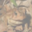

In [88]:
decode_img(img)

In [89]:
output=vae(adjust(torch.Tensor(img)[None, :]).to(device))[0]

In [91]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive
